<a href="https://colab.research.google.com/github/superjoe96/LSTM/blob/main/tcn_odl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, Dropout, LayerNormalization, Activation
from tensorflow.keras.layers import Add, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
df = pd.read_csv('personal_transactions_10000.csv')

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date
df = df.sort_values('Date')

# Create additional temporal features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

# Convert transaction type to numeric (1 for Credit, -1 for Debit)
df['TransactionValue'] = np.where(df['Transaction Type'] == 'credit', 1, -1)

# Encode categorical variables
label_encoders = {}
categorical_cols = ['Category', 'Account Name']

for col in categorical_cols:
    le = LabelEncoder()
    df[f'{col}_Encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

# Aggregate data by week for time series forecasting
weekly_data = df.groupby(pd.Grouper(key='Date', freq='W')).agg({
    'Amount': 'sum',
    'Transaction Type': 'count'  # Count of transactions per week
}).rename(columns={'Transaction Type': 'TransactionCount'})

date_range = pd.date_range(start=weekly_data.index.min(), end=weekly_data.index.max(), freq='W')
weekly_data = weekly_data.reindex(date_range, fill_value=0)

In [16]:
for i in range(1, 9):  # Create 8 lag features
    weekly_data[f'Amount_Lag_{i}'] = weekly_data['Amount'].shift(i)

# Create rolling statistics
weekly_data['Amount_RollingMean_4W'] = weekly_data['Amount'].rolling(window=4).mean()
weekly_data['Amount_RollingStd_4W'] = weekly_data['Amount'].rolling(window=4).std()

# Add month and quarter as cyclical features
weekly_data['Month'] = weekly_data.index.month
weekly_data['Quarter'] = weekly_data.index.quarter

# Create month and quarter as cyclical features
weekly_data['Month_sin'] = np.sin(2 * np.pi * weekly_data['Month'] / 12)
weekly_data['Month_cos'] = np.cos(2 * np.pi * weekly_data['Month'] / 12)
weekly_data['Quarter_sin'] = np.sin(2 * np.pi * weekly_data['Quarter'] / 4)
weekly_data['Quarter_cos'] = np.cos(2 * np.pi * weekly_data['Quarter'] / 4)

# Remove rows with NaN values (from the lag and rolling features)
weekly_data = weekly_data.dropna()


In [17]:
# Define the features and target
features = [f'Amount_Lag_{i}' for i in range(1, 9)] + \
           ['Amount_RollingMean_4W', 'Amount_RollingStd_4W',
            'Month_sin', 'Month_cos', 'Quarter_sin', 'Quarter_cos']

target = 'Amount'

# Split the data into training and testing sets (keeping the time series order)
train_size = int(len(weekly_data) * 0.7)
val_size = int(len(weekly_data) * 0.15)

train_data = weekly_data.iloc[:train_size]
val_data = weekly_data.iloc[train_size:train_size+val_size]
test_data = weekly_data.iloc[train_size+val_size:]

In [18]:
# Scale the features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(train_data[features])
y_train = scaler_y.fit_transform(train_data[[target]])

X_val = scaler_X.transform(val_data[features])
y_val = scaler_y.transform(val_data[[target]])

X_test = scaler_X.transform(test_data[features])
y_test = scaler_y.transform(test_data[[target]])

# Reshape input data for the TCN model [samples, timesteps, features]
# For TCN, we reshape the input to have a single timestep with all features
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val_reshaped = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [21]:
def residual_block(x, dilation_rate, nb_filters, kernel_size, padding, dropout_rate=0.1):
    """
    Defines the residual block for the TCN
    """
    prev_x = x

    # First dilated convolution
    x = Conv1D(filters=nb_filters,
               kernel_size=kernel_size,
               dilation_rate=dilation_rate,
               padding='causal',
               activation='linear')(x)
    x = LayerNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    # Second dilated convolution
    x = Conv1D(filters=nb_filters,
               kernel_size=kernel_size,
               dilation_rate=dilation_rate,
               padding='causal',
               activation='linear')(x)
    x = LayerNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    # If the number of filters changes, use a 1x1 conv to match dimensions
    if prev_x.shape[-1] != nb_filters:
        prev_x = Conv1D(filters=nb_filters, kernel_size=1, padding='same')(prev_x)

    # Add the residual connection
    res = Add()([prev_x, x])
    return res

def create_tcn_model(input_shape, output_units=1):
    """
    Creates an enhanced TCN model for time series prediction to address underfitting
    """
    # Enhanced hyperparameters
    nb_filters = 128  # Increased from 64 to 128 for more capacity
    kernel_size = 3   # Increased from 2 to 3 for wider receptive field
    nb_stacks = 2     # Increased from 1 to 2 for more depth
    dilations = [1, 2, 4, 8, 16, 32]  # Added higher dilation rate for longer dependencies
    dropout_rate = 0.1  # Reduced from 0.2 to prevent too much regularization when underfitting

    # Input layer
    inputs = Input(shape=input_shape)

    # TCN architecture with multiple stacks
    x = inputs
    for stack in range(nb_stacks):
        for dilation_rate in dilations:
            x = residual_block(x, dilation_rate, nb_filters, kernel_size, 'causal', dropout_rate)

    # Improved output layers with additional processing
    x = Lambda(lambda z: z[:, -1, :])(x)  # Extract last time step
    x = Dense(64, activation='relu')(x)    # Additional dense layer for better representation
    outputs = Dense(output_units)(x)

    # Create model
    model = Model(inputs, outputs)

    # Compile with adjusted learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0005),  # Reduced learning rate for more stable training
        loss='mse',
        metrics=['mae']
    )

    return model

# Create and compile the TCN model
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])  # (timesteps, features)
tcn_model = create_tcn_model(input_shape)

In [23]:
# 5. Train the TCN Model
# Define callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001),
    ModelCheckpoint('tcn_cashflow_model.h5', save_best_only=True, monitor='val_loss')
]

# Re-reshape inputs to use multiple timesteps which may help the TCN learn patterns better
# Instead of single timestep with all features, let's try using actual sequential data
# Reshape to [samples, sequence_length, features_per_step]
sequence_length = 8  # Using 8 weeks of historical data

def create_sequences(X, y, seq_length):
    """Convert feature matrix to sequences for better TCN training"""
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length + 1):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length-1])
    return np.array(X_seq), np.array(y_seq)

# Extract the original features before reshaping
X_train_original = X_train.copy()
X_val_original = X_val.copy()
X_test_original = X_test.copy()

# Create sequences for training
X_train_seq, y_train_seq = create_sequences(X_train_original, y_train, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val_original, y_val, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_original, y_test, sequence_length)

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
tcn_model = create_tcn_model(input_shape)

class_weight = None

# Train the model
history = tcn_model.fit(
    X_train_seq,
    y_train_seq,
    epochs=100,  # Increased epochs to allow more time to learn
    batch_size=32,  # Reduced batch size for better gradient estimates
    validation_data=(X_val_seq, y_val_seq),
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weight,
    shuffle=True  # Enable shuffling to prevent order-based biases
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 23.5439 - mae: 4.1993

6/6 ━━━━━━━━━━━━━━━━━━━━ 32s 611ms/step - loss: 23.3142 - mae: 4.1814 - val_loss: 4.6309 - val_mae: 1.9779 - learning_rate: 5.0000e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 5.3047 - mae: 2.0408

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - loss: 5.3837 - mae: 2.0516 - val_loss: 0.5113 - val_mae: 0.5201 - learning_rate: 5.0000e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 2.6163 - mae: 1.2882 - val_loss: 0.6625 - val_mae: 0.7132 - learning_rate: 5.0000e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 1.7157 - mae: 1.0682

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step - loss: 1.7517 - mae: 1.0790 - val_loss: 0.4016 - val_mae: 0.4541 - learning_rate: 5.0000e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 1.1106 - mae: 0.8692

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 1.1129 - mae: 0.8689 - val_loss: 0.2799 - val_mae: 0.4047 - learning_rate: 5.0000e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 0.8934 - mae: 0.7512 - val_loss: 0.3988 - val_mae: 0.4909 - learning_rate: 5.0000e-04
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.6745 - mae: 0.6588

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.6799 - mae: 0.6595 - val_loss: 0.2500 - val_mae: 0.3762 - learning_rate: 5.0000e-04
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - loss: 0.5544 - mae: 0.5643 - val_loss: 0.3507 - val_mae: 0.4569 - learning_rate: 5.0000e-04
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.7079 - mae: 0.6689 - val_loss: 0.3633 - val_mae: 0.4972 - learning_rate: 5.0000e-04
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - loss: 0.7376 - mae: 0.7036 - val_loss: 0.3132 - val_mae: 0.4231 - learning_rate: 5.0000e-04
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.7497 - mae: 0.7188

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.7439 - mae: 0.7150 - val_loss: 0.2069 - val_mae: 0.3393 - learning_rate: 5.0000e-04
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.5697 - mae: 0.6072 - val_loss: 0.2468 - val_mae: 0.3643 - learning_rate: 5.0000e-04
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - loss: 0.5470 - mae: 0.6095 - val_loss: 0.2942 - val_mae: 0.4101 - learning_rate: 5.0000e-04
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - loss: 0.5140 - mae: 0.5717 - val_loss: 0.2489 - val_mae: 0.3913 - learning_rate: 5.0000e-04
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 0.5748 - mae: 0.6169 - val_loss: 0.4696 - val_mae: 0.5688 - learning_rate: 5.0000e-04
Epoch 16/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.6208 - mae: 0.6590 - val_loss: 0.3856 - val_mae: 0.5262 - learning_rate: 5.0000e-04
Epoch 17/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 0.7529 - mae: 0.7100 - val_loss: 0.2773 - val_mae: 0.4270 - learning_rate: 5.

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 0.5958 - mae: 0.6086 - val_loss: 0.1902 - val_mae: 0.3466 - learning_rate: 5.0000e-04
Epoch 21/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 0.3945 - mae: 0.4944 - val_loss: 0.1983 - val_mae: 0.3575 - learning_rate: 5.0000e-04
Epoch 22/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 0.4355 - mae: 0.5282 - val_loss: 0.2418 - val_mae: 0.3906 - learning_rate: 5.0000e-04
Epoch 23/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.3914 - mae: 0.5262

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step - loss: 0.3871 - mae: 0.5214 - val_loss: 0.1883 - val_mae: 0.3245 - learning_rate: 5.0000e-04
Epoch 24/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.3569 - mae: 0.4811

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - loss: 0.3531 - mae: 0.4779 - val_loss: 0.1743 - val_mae: 0.3235 - learning_rate: 5.0000e-04
Epoch 25/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.4353 - mae: 0.5393

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - loss: 0.4345 - mae: 0.5385 - val_loss: 0.1626 - val_mae: 0.2952 - learning_rate: 5.0000e-04
Epoch 26/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.3501 - mae: 0.4964

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 0.3536 - mae: 0.4970 - val_loss: 0.1519 - val_mae: 0.2885 - learning_rate: 5.0000e-04
Epoch 27/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 0.3857 - mae: 0.4774 - val_loss: 0.1580 - val_mae: 0.3123 - learning_rate: 5.0000e-04
Epoch 28/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.3945 - mae: 0.4973 - val_loss: 0.1881 - val_mae: 0.3372 - learning_rate: 5.0000e-04
Epoch 29/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 0.3148 - mae: 0.4245 - val_loss: 0.1549 - val_mae: 0.3077 - learning_rate: 5.0000e-04
Epoch 30/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.3803 - mae: 0.4977 - val_loss: 0.1608 - val_mae: 0.3124 - learning_rate: 5.0000e-04
Epoch 31/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.2755 - mae: 0.4171

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 0.2776 - mae: 0.4183 - val_loss: 0.1360 - val_mae: 0.2956 - learning_rate: 5.0000e-04
Epoch 32/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.3312 - mae: 0.4510

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step - loss: 0.3282 - mae: 0.4487 - val_loss: 0.1180 - val_mae: 0.2767 - learning_rate: 5.0000e-04
Epoch 33/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 0.3609 - mae: 0.4738 - val_loss: 0.1450 - val_mae: 0.3108 - learning_rate: 5.0000e-04
Epoch 34/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3001 - mae: 0.4371

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.3005 - mae: 0.4379 - val_loss: 0.1102 - val_mae: 0.2623 - learning_rate: 5.0000e-04
Epoch 35/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 0.3437 - mae: 0.4596 - val_loss: 0.1286 - val_mae: 0.2660 - learning_rate: 5.0000e-04
Epoch 36/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 0.3823 - mae: 0.4945 - val_loss: 0.1290 - val_mae: 0.2707 - learning_rate: 5.0000e-04
Epoch 37/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 0.2684 - mae: 0.4158 - val_loss: 0.1329 - val_mae: 0.2759 - learning_rate: 5.0000e-04
Epoch 38/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 0.2733 - mae: 0.4203 - val_loss: 0.1904 - val_mae: 0.3563 - learning_rate: 5.0000e-04
Epoch 39/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 0.3212 - mae: 0.4459 - val_loss: 0.1192 - val_mae: 0.2499 - learning_rate: 5.0000e-04
Epoch 40/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - loss: 0.2837 - mae: 0.4451 - val_loss: 0.1356 - val_mae: 0.2859 - learning_rate: 5.

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - loss: 0.2866 - mae: 0.4131 - val_loss: 0.0953 - val_mae: 0.2407 - learning_rate: 5.0000e-04
Epoch 44/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 0.2562 - mae: 0.3964 - val_loss: 0.1008 - val_mae: 0.2620 - learning_rate: 5.0000e-04
Epoch 45/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1795 - mae: 0.3401

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 0.1785 - mae: 0.3393 - val_loss: 0.0891 - val_mae: 0.2392 - learning_rate: 5.0000e-04
Epoch 46/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.1993 - mae: 0.3590

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - loss: 0.2019 - mae: 0.3611 - val_loss: 0.0874 - val_mae: 0.2357 - learning_rate: 5.0000e-04
Epoch 47/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.2467 - mae: 0.3933 - val_loss: 0.1274 - val_mae: 0.2919 - learning_rate: 5.0000e-04
Epoch 48/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - loss: 0.2415 - mae: 0.3971 - val_loss: 0.1048 - val_mae: 0.2534 - learning_rate: 5.0000e-04
Epoch 49/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 0.2114 - mae: 0.3583 - val_loss: 0.1021 - val_mae: 0.2457 - learning_rate: 5.0000e-04
Epoch 50/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 0.2186 - mae: 0.3618 - val_loss: 0.1515 - val_mae: 0.3289 - learning_rate: 5.0000e-04
Epoch 51/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 0.2353 - mae: 0.3881 - val_loss: 0.1125 - val_mae: 0.2523 - learning_rate: 5.0000e-04
Epoch 52/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.2460 - mae: 0.3801 - val_loss: 0.1003 - val_mae: 0.2378 - learning_rate: 5.

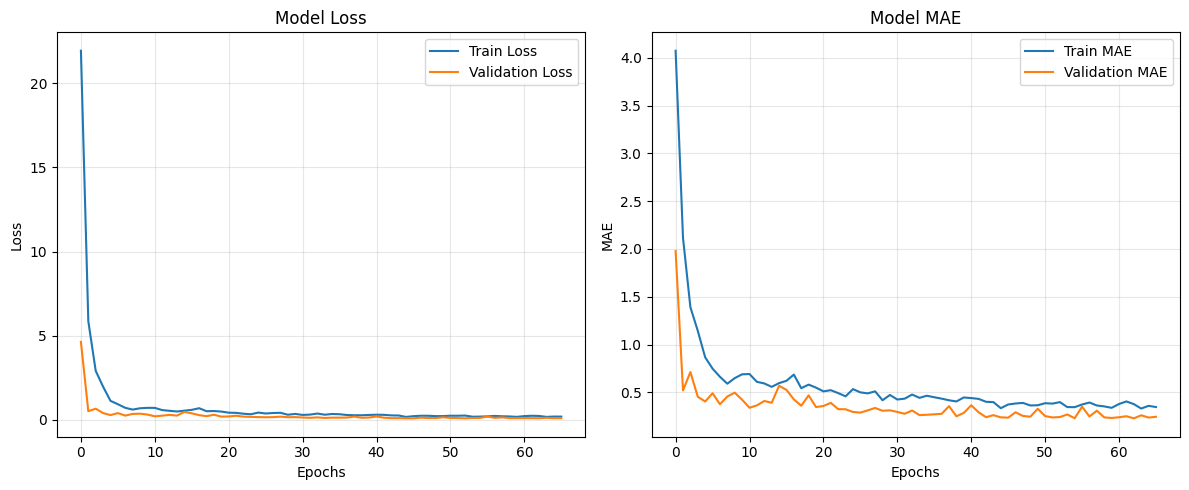

In [24]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
# 6. Evaluate the Enhanced TCN Model
# Make predictions on test set
y_pred = tcn_model.predict(X_test_seq)

# Inverse transform predictions and actual values to original scale
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test_seq)

# Calculate metrics
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print("Model Evaluation Metrics:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Model Evaluation Metrics:
MSE: 7144591.01
RMSE: 2672.94
MAE: 2032.27
R²: 0.88


Improvement over naive baseline: 79.16%


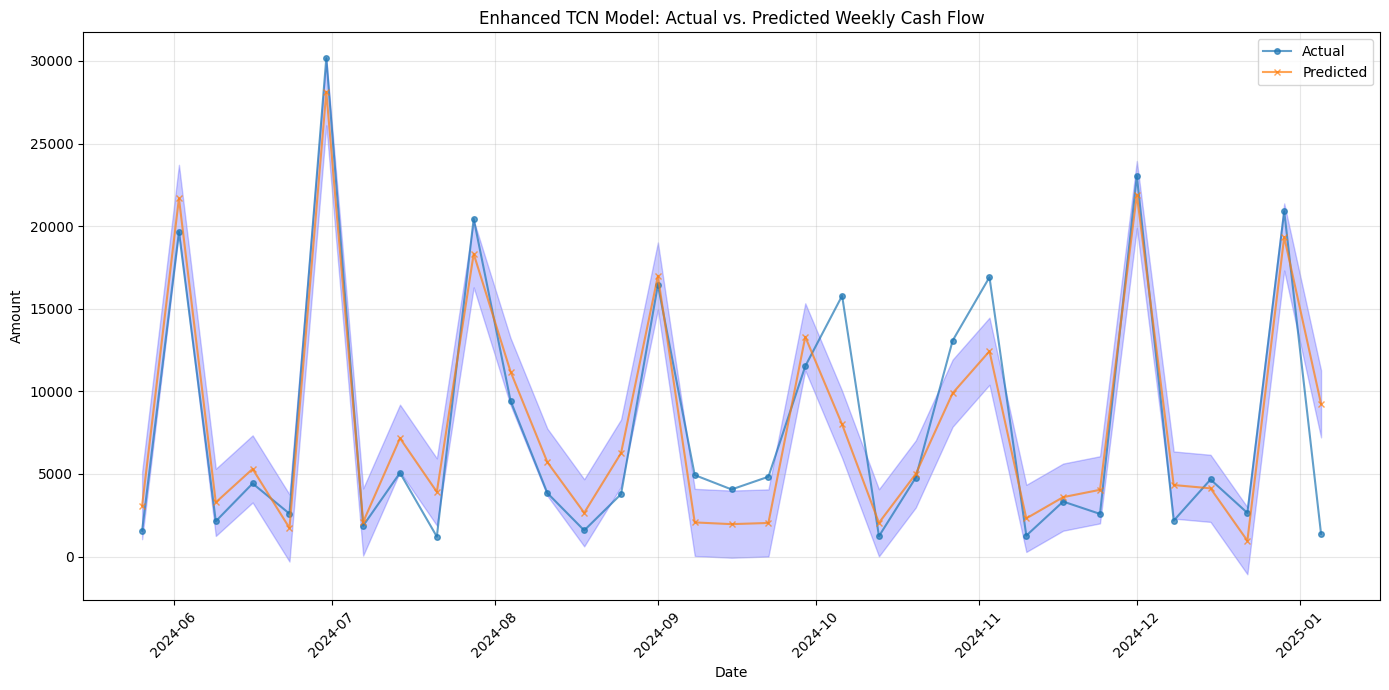

In [32]:
# Calculate percentage improvement compared to baseline
# (Assuming a naive baseline that just predicts the previous value)
y_naive = y_test_seq[:-1]  # Previous values as prediction
y_actual = y_test_seq[1:]  # Actual values to compare against

naive_mae = mean_absolute_error(scaler_y.inverse_transform(y_actual),
                              scaler_y.inverse_transform(y_naive))
improvement = (naive_mae - mae) / naive_mae * 100

print(f"Improvement over naive baseline: {improvement:.2f}%")

# Get the actual dates for the test set (adjusted for sequence length)
test_dates = test_data.index[sequence_length-1:]
if len(test_dates) > len(y_test_original):
    test_dates = test_dates[:len(y_test_original)]
elif len(test_dates) < len(y_test_original):
    # This shouldn't happen, but just in case
    y_test_original = y_test_original[:len(test_dates)]
    y_pred_original = y_pred_original[:len(test_dates)]

# Plot actual vs. predicted values with improved visualization
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_original, label='Actual', marker='o', alpha=0.7, markersize=4)
plt.plot(test_dates, y_pred_original, label='Predicted', marker='x', alpha=0.7, markersize=4)
plt.title('Enhanced TCN Model: Actual vs. Predicted Weekly Cash Flow')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Add shaded area for prediction confidence interval
plt.fill_between(test_dates,
                y_pred_original.flatten() - mae,
                y_pred_original.flatten() + mae,
                alpha=0.2, color='blue',
                label='MAE Confidence')

plt.tight_layout()
plt.show()

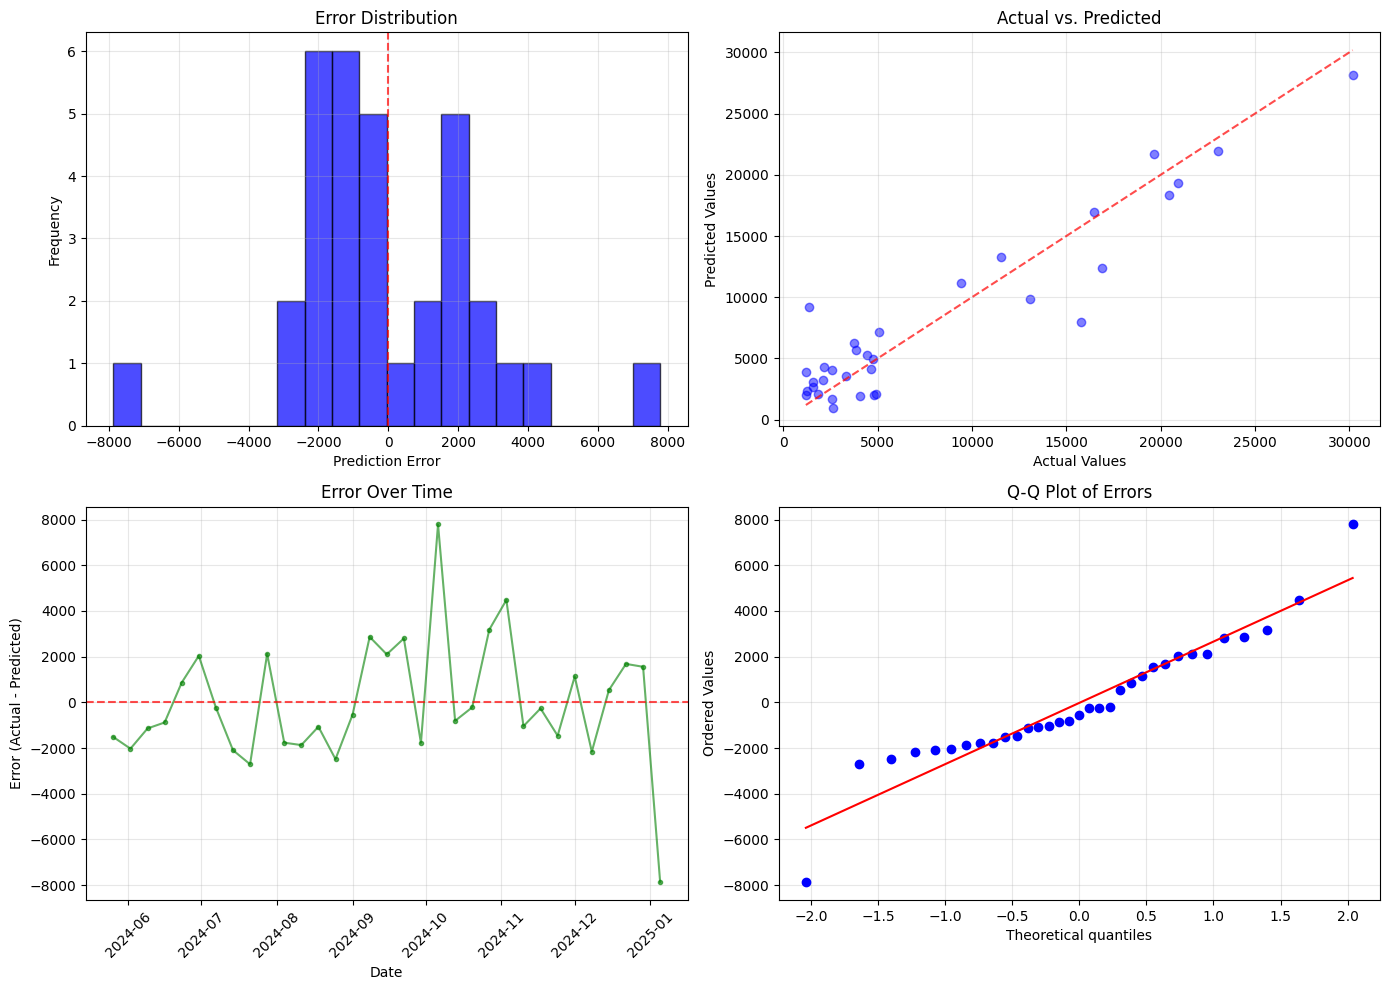

In [33]:
# Calculate and plot error distribution with additional analysis
errors = y_test_original - y_pred_original

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.hist(errors, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)

plt.subplot(2, 2, 2)
plt.scatter(y_test_original, y_pred_original, alpha=0.5, color='blue')
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         'r--', alpha=0.7)
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(test_dates, errors, color='green', marker='o', linestyle='-', alpha=0.6, markersize=3)
plt.title('Error Over Time')
plt.xlabel('Date')
plt.ylabel('Error (Actual - Predicted)')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
from scipy import stats
stats.probplot(errors.flatten(), plot=plt)
plt.title('Q-Q Plot of Errors')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()